In [1]:
import json
import infosys.utils as utils 
import igraph as ig
import os
import collections
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl
import collections
import sys

In [2]:
def get_exp_network_map(config_fname):
    exp_configs = json.load(open(config_fname,'r'))
    EXPS = list(exp_configs['vary_thetaphi'].keys()) #keys are name of exp, format: '{targeting}_{thetaidx}{phiidx}' 

    # map available network in `vary_targetgamma` corresponding with the exp
    # networks from `vary_targetgamma` has format: '{targeting}{gamma}'
    GAMMA = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.02, 0.05, 0.1, 0.2, 0.5]
    TARGETING = [None, 'hubs', 'partisanship', 'conservative', 'liberal', 'misinformation']

    EXP_NETWORK = {}

    gamma = 0.1 # gamma in the range where targeting has some effect
    # need to match with default_targeting
    for exp in EXPS:
        if 'none' in exp:
            networkname = '%s%s' %(TARGETING.index(None), GAMMA.index(gamma))
        else: 
            networkname = '%s%s' %(TARGETING.index(exp.split('_')[0]), GAMMA.index(gamma) )
        EXP_NETWORK[exp] = networkname

    return EXP_NETWORK

In [3]:
def info_memeshares_channel_indegs(G, verbose, deg_mode='in'):
    # Helper: Scatter plot of number of shares vs indeg of spreading channel (for junk memes)
    # return a dict of information to calculate: 
    # % of memes spread only by bot; num shares, indeg of nodes spreading each meme
    # (Stats across simulation)

    info = collections.defaultdict(lambda:[])
    keys= ['num_humans', 'num_bots', 'human_spread_only_viabot', 'bot_spread_only_viabot']
    for k in keys:
        info[k] = 0

    human_agents = [int(node['id']) for node in G.vs if node['bot']==0]

    for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
        spread_through = [int(node) for node in meme['spread_via_agents']]
        human_channels = set(human_agents) & set(spread_through)

        if len(human_channels)>0:
            indegs = G.degree(list(human_channels), mode=deg_mode, loops=False)
            largest_indeg = max(indegs)
            
            if meme['is_by_bot']==1:
                info['num_bots']+=1
                info['bot_largest_spreading_nodes'] += [largest_indeg]  
                info['botmeme_shares'] += [meme['human_shares']]
                info['botmeme_fitness'] += [meme['fitness']]
            else:
                info['num_humans']+=1
                info['human_largest_spreading_nodes'] += [largest_indeg]
                info['humanmeme_shares'] += [meme['human_shares']]
                info['humanmeme_fitness'] += [meme['fitness']]
                info['humanmeme_quality'] += [meme['quality']]
        else:
            if meme['is_by_bot']==1:
                info['bot_spread_only_viabot']+=1
            else:
                info['human_spread_only_viabot']+=1
        
    return info

In [4]:
ABS_PATH = '/N/slate/baotruon/marketplace'
DATA_PATH = '/N/slate/baotruon/marketplace/data'

config_fname= os.path.join(DATA_PATH, 'all_configs.json')
exp2network = get_exp_network_map(config_fname)

# CHANGE THESE VARS FOR OTHER INFILTRATION VALUES
exp = 'vary_thetaphi_1runs_gamma0.005'
hub_expname='hubs_22'
none_expname='none_22'

RES_DIR = os.path.join(ABS_PATH,'results', exp)
TRACKING_DIR = os.path.join(ABS_PATH,'long_results',exp)
NETWORK_PATH = os.path.join(DATA_PATH, 'igraph/vary_targetgamma')

hub_network = os.path.join(NETWORK_PATH, "network_%s.gml" %exp2network[hub_expname])
hub_verbose = utils.read_json_compressed(os.path.join(TRACKING_DIR,'%s.json.gz' %hub_expname))
hub_graph = ig.Graph.Read_GML(hub_network)

none_network = os.path.join(NETWORK_PATH, "network_%s.gml" %exp2network[none_expname])
none_verbose = utils.read_json_compressed(os.path.join(TRACKING_DIR,'%s.json.gz' %none_expname))
none_graph = ig.Graph.Read_GML(none_network)


hubstrag_info = info_memeshares_channel_indegs(hub_graph, hub_verbose, deg_mode='in')
nostrag_info =  info_memeshares_channel_indegs(none_graph, none_verbose, deg_mode='in')

## Check significance of dist. of shares (bot memes) between 2 strategy

In [5]:
def ccdf_share_between_strategies(nostrag_botshares, strag_botshares, plot_fpath=None, log_log=True):
    # CCDF of shares of bot memes - 2 lines (none & hubs-targeting)

    figure, ax = plt.subplots()

    if log_log is True:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    sns.ecdfplot(ax=ax, data = nostrag_botshares, complementary=True, label = 'no targeting')
    sns.ecdfplot(ax=ax, data = strag_botshares, complementary=True, label = 'hub targeting')
    ax.set_xlabel('Number of shares')
    ax.legend()
    ax.set_title('CCDF: Number of shares (bot memes) between strategies')

    figure.tight_layout()
    if plot_fpath is not None:
        figure.savefig(plot_fpath, dpi=300)
        plt.close(figure)
    else:
        figure.show()

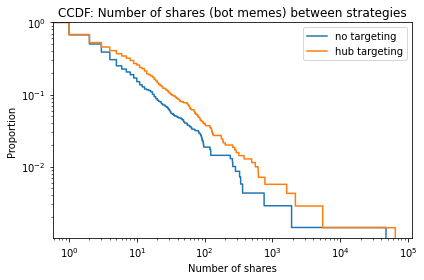

In [6]:
ccdf_share_between_strategies(nostrag_info['botmeme_shares'], hubstrag_info['botmeme_shares'],log_log=True)

We want to check if the difference between 2 distributions above is significant

In [11]:
utils.ks_test(nostrag_info['botmeme_shares'], hubstrag_info['botmeme_shares'], alpha=0.01, verbose=True)

KstestResult(statistic=0.11752136752136752, pvalue=0.00011294908758296973)
Statistic is larger than critical value
The 2 distributions are similar: False (At alpha 0.01, D=0.087)


False

In [15]:
len(hubstrag_info['botmeme_shares'])

702

In [17]:
sample_size= int(min(len(hubstrag_info['botmeme_shares']), len(nostrag_info['botmeme_shares']))*0.6)
test_results =[] #whether 2 distributions are similar
for i in range(10):
    nostragsample = np.random.choice(nostrag_info['botmeme_shares'], replace=False,size=sample_size)
    hubstragsample = np.random.choice(hubstrag_info['botmeme_shares'], replace=False,size=sample_size)
    test_results += [utils.ks_test(nostragsample,hubstragsample, alpha=0.01)]

In [18]:
test_results

[False, False, False, True, True, False, False, False, False, False]

Difference is siginificance. But how about when we limit the duration of the simulation? Is there still a difference?

In [ ]:
def info_memeshares_channel_indegs(G, verbose, deg_mode='in', duration_limit=None):
    # Helper: Scatter plot of number of shares vs indeg of spreading channel (for junk memes)
    # return a dict of information to calculate: 
    # % of memes spread only by bot; num shares, indeg of nodes spreading each meme
    # (Stats across simulation)

    info = collections.defaultdict(lambda:[])
    keys= ['num_humans', 'num_bots', 'human_spread_only_viabot', 'bot_spread_only_viabot']
    for k in keys:
        info[k] = 0

    human_agents = [int(node['id']) for node in G.vs if node['bot']==0]

    for meme in verbose['all_memes'][0]: #since verbose['all_memes'] is a list over multiple simulations
        spread_through = [int(node) for node in meme['spread_via_agents']]
        human_channels = set(human_agents) & set(spread_through)

        if len(human_channels)>0:
            indegs = G.degree(list(human_channels), mode=deg_mode, loops=False)
            largest_indeg = max(indegs)
            
            if meme['is_by_bot']==1:
                info['num_bots']+=1
                info['bot_largest_spreading_nodes'] += [largest_indeg]  
                info['botmeme_shares'] += [meme['human_shares']]
                info['botmeme_fitness'] += [meme['fitness']]
            else:
                info['num_humans']+=1
                info['human_largest_spreading_nodes'] += [largest_indeg]
                info['humanmeme_shares'] += [meme['human_shares']]
                info['humanmeme_fitness'] += [meme['fitness']]
                info['humanmeme_quality'] += [meme['quality']]
        else:
            if meme['is_by_bot']==1:
                info['bot_spread_only_viabot']+=1
            else:
                info['human_spread_only_viabot']+=1
        
    return info

Text(0.5, 1.0, 'CCDF: Number of shares (bot memes) between strategies')

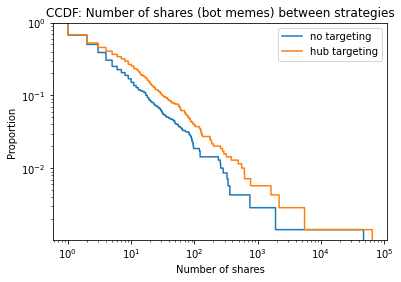

In [8]:
nostrag_botshares = nostrag_info['botmeme_shares']
strag_botshares = hubstrag_info['botmeme_shares']
duration = min(len(nostrag_botshares), len(strag_botshares))
nostrag_botshares = nostrag_botshares[:duration]
strag_botshares = strag_botshares[:duration]

assert )_
figure, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

sns.ecdfplot(ax=ax, data = nostrag_botshares, complementary=True, label = 'no targeting')
sns.ecdfplot(ax=ax, data = strag_botshares, complementary=True, label = 'hub targeting')
ax.set_xlabel('Number of shares')
ax.legend()
ax.set_title('CCDF: Number of shares (bot memes) between strategies')

#figure.show()

In [23]:
def ccdf_viahubshares_between_strategies(spreading_nodes, meme_shares, strag_spreading_nodes, strag_meme_shares, hubsize=1000, plot_fpath=None, log_log=True):
    # CCDF of the shares (of bot memes) - 2 lines (no target vs target), 2 panels (via hubs vs not via hub)
    viahub, not_viahub = separate_shares_viahubs(spreading_nodes, meme_shares, hubsize=hubsize)
    strag_viahub, strag_not_viahub = separate_shares_viahubs(strag_spreading_nodes, strag_meme_shares, hubsize=hubsize)
    
    figure, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)

    sns.ecdfplot(ax=ax1, data = viahub, complementary=True, label = 'no targeting')
    sns.ecdfplot(ax=ax1, data = strag_viahub, complementary=True, label = 'targeting')

    ax1.legend()
    if log_log is True:
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    sns.ecdfplot(ax=ax2, data = not_viahub, complementary=True, label = 'no targeting')
    sns.ecdfplot(ax=ax2, data = strag_not_viahub, complementary=True, label = 'targeting')

    ax1.set_title('Via hubs')
    ax2.set_title('Not via hub')
    ax1.set_xlabel('Shares')
    ax2.set_xlabel('Shares')

    figure.suptitle('CCDF: Number of shares of bot memes')
    figure.tight_layout()
    if plot_fpath is not None:
        figure.savefig(plot_fpath, dpi=300)
        plt.close(figure)
    else:
        plt.show()

def separate_shares_viahubs(spreading_degs, meme_shares, hubsize=1000):
# Helper ccdf_viahubshares, ccdf_viahubfitness
    viahub = []
    not_viahub = []
    for deg,share in zip(spreading_degs, meme_shares):
        if deg>=hubsize:
            viahub+=[share]
        else:
            not_viahub +=[share]
    return viahub, not_viahub

In [21]:
none_bot_spread= nostrag_info['bot_largest_spreading_nodes']
hubs_bot_spread= hubstrag_info['bot_largest_spreading_nodes']

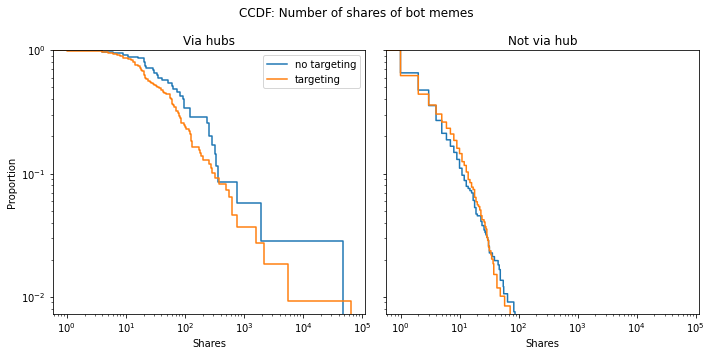

In [24]:
ccdf_viahubshares_between_strategies(none_bot_spread, nostrag_info['botmeme_shares'], hubs_bot_spread, hubstrag_info['botmeme_shares'], hubsize=1000,
                                        log_log=True)

In [28]:
hubsize=1000
spreading_nodes = none_bot_spread
meme_shares= nostrag_info['botmeme_shares']
strag_spreading_nodes = hubs_bot_spread
strag_meme_shares = hubstrag_info['botmeme_shares']

In [29]:
viahub, not_viahub = separate_shares_viahubs(spreading_nodes, meme_shares, hubsize=hubsize)
strag_viahub, strag_not_viahub = separate_shares_viahubs(strag_spreading_nodes, strag_meme_shares, hubsize=hubsize)

In [30]:
utils.ks_test(viahub, strag_viahub, alpha=0.01, verbose=True)

KstestResult(statistic=0.1782437745740498, pvalue=0.321943274575309)
Statistic is larger than critical value
The 2 distributions are similar: True (At alpha 0.01, D=0.317)


True

In [34]:
def kstest_multiple(dist1, dist2):
    sample_size= int(min(len(dist1), len(dist2))*0.6)
    test_results =[] #whether 2 distributions are similar
    for i in range(10):
        dist1_sample = np.random.choice(dist1, replace=False,size=sample_size)
        dist2_sample = np.random.choice(dist2, replace=False,size=sample_size)
        test_results += [utils.ks_test(dist1_sample, dist2_sample, alpha=0.01)]
    print(test_results)

In [35]:
kstest_multiple(viahub, strag_viahub)

[True, True, True, True, True, True, True, True, True, True]


# Check maximum of bot fraction

In [9]:
def final_botmeme_fraction(G, verbose):
    # Stat final state
    # Helper for plotting fraction of bot memes vs node in degree
    # Note: feed keys are strings, meme ids and all other keys are ints
    deg_mode='in'

    human_nodes = [int(node['id']) for node in G.vs if node['bot']==0]
    human_agents = [node['uid'] for node in G.vs if node['bot']==0]
    hum_degrees = G.degree(human_nodes, mode=deg_mode, loops=False)

    botmeme_ids = [meme['id'] for meme in verbose['all_memes'][0] if meme['is_by_bot']==1]

    final_agent_info ={}
    
    for idx, agentid in enumerate(human_agents):
        memeids = verbose['all_feeds'][0][agentid]
        
        if len(memeids)>0:
            bot_num= len([memeid for memeid in memeids if memeid in botmeme_ids])
            assert(bot_num<=len(memeids))

            bot_frac = bot_num/len(memeids)
            final_agent_info[agentid] = {'in_degree': hum_degrees[idx],
                                        'botmeme_frac': bot_frac}

    agent_indegs = [info['in_degree'] for info in final_agent_info.values()]
    botfrac_on_feed=[info['botmeme_frac'] for info in final_agent_info.values()]

    return agent_indegs, botfrac_on_feed

In [15]:
sorted([3,4,1])

[1, 3, 4]

In [50]:
def convert_to_range(old_value):
    old_min = 0
    old_max=1 
    new_min=0.95 
    new_max=1
    new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
    return new_value

In [51]:
def ccdf_botmemefrac_between_strategies(nostrag_junkfrac, strag_junkfrac, plot_fpath=None, log_log=False, tail=False):
    # CCDF of fraction of bot memes in human agent's feeds at final state- 2 lines (none & hubs-targeting)

    figure, ax = plt.subplots()

    if log_log is True:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    if tail is True:
        nostrag_junkfrac = sorted(nostrag_junkfrac)[int(len(nostrag_junkfrac)*0.95):]
        strag_junkfrac = sorted(strag_junkfrac)[int(len(strag_junkfrac)*0.95):]
        ticks=[]
        for i in ax.get_xticks():
            ticks +=[convert_to_range(i)]
        ax.set_yticklabels(ticks)
        
    sns.ecdfplot(ax=ax, data = nostrag_junkfrac, complementary=True, label = 'no targeting')
    sns.ecdfplot(ax=ax, data = strag_junkfrac, complementary=True, label = 'hub targeting')
    ax.set_xlabel("Fraction of bot memes in agent's feed")
    ax.legend()
    ax.set_title("CCDF: Fraction of bot memes in agent's feed")
    
    figure.tight_layout()
    if plot_fpath is not None:
        figure.savefig(plot_fpath, dpi=300)
        plt.close(figure)
    else:
        figure.show()

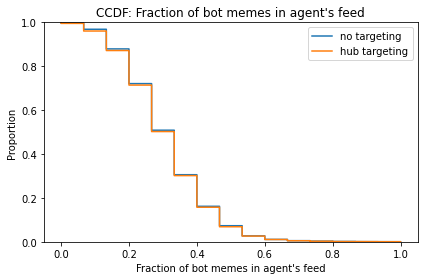

In [23]:
nostrag_agentdegs, nostrag_botfrac=final_botmeme_fraction(none_graph, none_verbose)
strag_agentdegs, strag_botfrac=final_botmeme_fraction(hub_graph, hub_verbose)
ccdf_botmemefrac_between_strategies(nostrag_botfrac, strag_botfrac)

^ There could be some difference in the tail of these 2 distributions. Could there be a giant human node that focuses all the bot memes?

In [13]:
max(nostrag_botfrac) 

1.0

In [14]:
max(strag_botfrac)

1.0

/N/u/baotruon/Carbonate/miniconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


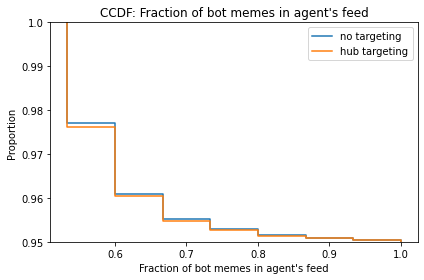

In [52]:
ccdf_botmemefrac_between_strategies(nostrag_botfrac, strag_botfrac, tail=True)

# Plot bot vs human degree distribution

In [65]:
def plot_agent_degree_dist(graph, mode='in', plot_fpath=None):
    
    human_vertices = [v for v in graph.vs if v['bot']==0]
    human_degs = graph.degree(human_vertices, mode=mode, loops=False)
    
    bot_vertices = [v for v in graph.vs if v['bot']==1]
    bot_degs = graph.degree(bot_vertices, mode=mode, loops=False)
    
    figure, ax = plt.subplots()
    ax.set_xscale('log')
    ax.set_yscale('log')
    sns.ecdfplot(ax=ax, data = human_degs, complementary=True, label = 'human')
    sns.ecdfplot(ax=ax, data = bot_degs, complementary=True, label = 'bot')
    ax.set_xlabel("Degree")
    ax.legend()
    ax.set_title("CCDF: Degree dist. of agents")
    figure.tight_layout()
    if plot_fpath is not None:
        figure.savefig(plot_fpath, dpi=300)
        plt.close(figure)
    else:
        figure.show()

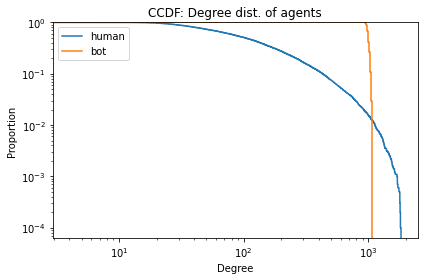

In [66]:
plot_agent_degree_dist(none_graph, mode='in')

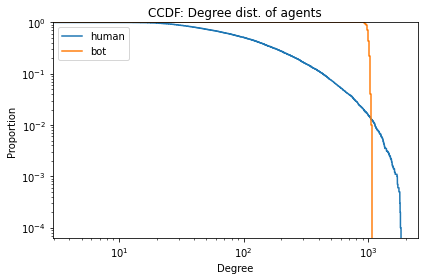

In [68]:
plot_agent_degree_dist(hub_graph, mode='in')

In [55]:

humans[0]

igraph.Vertex(<igraph.Graph object at 0x2ab3d8535450>, 0, {'id': 0.0, 'party': '-0.28911836734693874', 'misinfo': '0.0', 'bot': 0.0, 'uid': '65537'})

In [69]:
ABS_PATH = '/N/slate/baotruon/marketplace'
DATA_PATH = '/N/slate/baotruon/marketplace/data'

config_fname= os.path.join(DATA_PATH, 'all_configs.json')
exp2network = get_exp_network_map(config_fname)

# CHANGE THESE VARS FOR OTHER INFILTRATION VALUES
exp = 'vary_thetaphi_1runs_gamma0.0005'
hub_expname='hubs_22'
none_expname='none_22'

RES_DIR = os.path.join(ABS_PATH,'results', exp)
TRACKING_DIR = os.path.join(ABS_PATH,'long_results',exp)
NETWORK_PATH = os.path.join(DATA_PATH, 'igraph/vary_targetgamma')

hub_network = os.path.join(NETWORK_PATH, "network_%s.gml" %exp2network[hub_expname])
hub_graph = ig.Graph.Read_GML(hub_network)

none_network = os.path.join(NETWORK_PATH, "network_%s.gml" %exp2network[none_expname])
none_graph = ig.Graph.Read_GML(none_network)


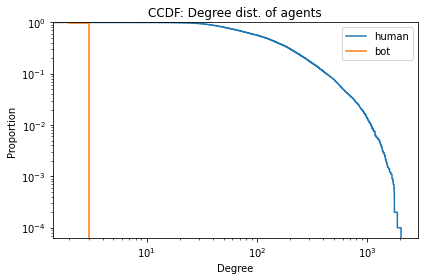

In [81]:
plot_agent_degree_dist(none_graph, mode='out')

In [71]:
humans = [v for v in none_graph.vs if v['bot']==0]
len(humans)

10006

In [72]:
10000*0.005

50.0

Check that the range of bot degree is correct

In [74]:
import random
gamma=0.005

In [75]:
degs = []
for i in range(100):
    n_followers=0
    for _ in range(10006):
        if random.random() < gamma:
            n_followers += 1
    degs +=[n_followers]

(array([ 2.,  2., 11., 17., 21., 25., 10.,  7.,  2.,  3.]),
 array([34. , 37.3, 40.6, 43.9, 47.2, 50.5, 53.8, 57.1, 60.4, 63.7, 67. ]),
 <BarContainer object of 10 artists>)

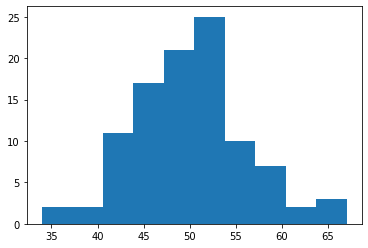

In [76]:
plt.hist(degs)

In [79]:
bot_vertices = [v for v in none_graph.vs if v['bot']==1]
bot_degs = none_graph.degree(bot_vertices, mode='in', loops=False)

(array([ 6.,  8., 17., 14., 17., 12., 12.,  8.,  3.,  3.]),
 array([ 943. ,  956.6,  970.2,  983.8,  997.4, 1011. , 1024.6, 1038.2,
        1051.8, 1065.4, 1079. ]),
 <BarContainer object of 10 artists>)

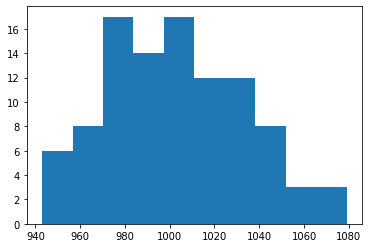

In [80]:
plt.hist(bot_degs)